## Reading data, calculating signal change and storing the result to mat file

In [1]:
%matplotlib widget
import os
import numpy as np
import h5py

tissue_type = 0 # 0 = extra-vascular, 1 = intra-vascular, [0,1] = combined
oxy_level = [78, 85]
results_dir = './BVF/outputs/'

def read_results(filename):
    signal_magnitude = []       
    filepath = os.path.join(results_dir, f'{filename}.h5')
    with h5py.File(filepath, 'r') as h5:
        M = np.array(h5['M'])
        T = np.array(h5['T'])                
        S = np.array(h5['scales'])  
        for ids, s in enumerate(S):
            mask = (T[ids, :, 0, 0] == tissue_type)
            M_f = M[ids, mask, 0, :]      
            # M_f = M[ids, :, 0, :]        
            M_f = np.sum(M_f[...,0:2], axis=0)            
            signal_magnitude.append(np.linalg.norm(M_f))    
    return signal_magnitude


############
radius = 8
BVF = [1, 2, 3, 4, 5, 6]
print("Reading GRE...")
signal_change_gre = []
for idb, b in enumerate(BVF):
    signal_magnitude = []
    for o in oxy_level:
        filename = f'gre_{o}_r{radius}_Y0.0_BVF{b}_ori90_fov600_res1200'
        signal_magnitude.append(read_results(filename))
    signal_magnitude = np.array(signal_magnitude)
    signal_change_gre.append(100 * (1 - signal_magnitude[0,:] / signal_magnitude[1,:]))

print("Reading SE...")
signal_change_se = []
for idb, b in enumerate(BVF):
    signal_magnitude = []
    for o in oxy_level:
        filename = f'se_{o}_r{radius}_Y0.0_BVF{b}_ori90_fov600_res1200'
        signal_magnitude.append(read_results(filename))
    signal_magnitude = np.array(signal_magnitude)
    signal_change_se.append(100 * (1 - signal_magnitude[0,:] / signal_magnitude[1,:]))

print("Reading bSSFP...")
signal_change_ssfp = []
for idb, b in enumerate(BVF):
    signal_magnitude = []
    for o in oxy_level:
        filename = f'ssfp_{o}_r{radius}_Y0.0_BVF{b}_ori90_fov600_res1200'
        signal_magnitude.append(read_results(filename))
    signal_magnitude = np.array(signal_magnitude)
    signal_change_ssfp.append(100 * (1 - signal_magnitude[0,:] / signal_magnitude[1,:]))

with h5py.File(os.path.join(results_dir, f'{filename}.h5'), 'r') as h5:
    scales = np.array(h5['scales']) 

# save as mat file
import scipy.io as sio
print("Saving the results.")
sio.savemat(os.path.join(results_dir, 'signal_change.mat'), {'radius':radius, 'scales':scales, 'signal_change_gre': signal_change_gre, 'signal_change_se': signal_change_se, 'signal_change_ssfp': signal_change_ssfp})


Reading GRE...
Reading SE...
Reading bSSFP...
Saving the results.


## Import preprocessed results

In [1]:
# load mat file
import os
import numpy as np
import scipy.io as sio
results_dir = '/DATA2/microvascular/cylinder/BVF/outputs/'
data = sio.loadmat(os.path.join(results_dir, 'signal_change.mat'))
signal_change_gre  = np.array(data['signal_change_gre'])
signal_change_se   = np.array(data['signal_change_se'])
signal_change_ssfp = np.array(data['signal_change_ssfp'])
scales = data['scales']
radius = data['radius']
print(signal_change_gre.shape, signal_change_se.shape, signal_change_ssfp.shape)


(6, 50) (6, 50) (6, 50)


## Plot results

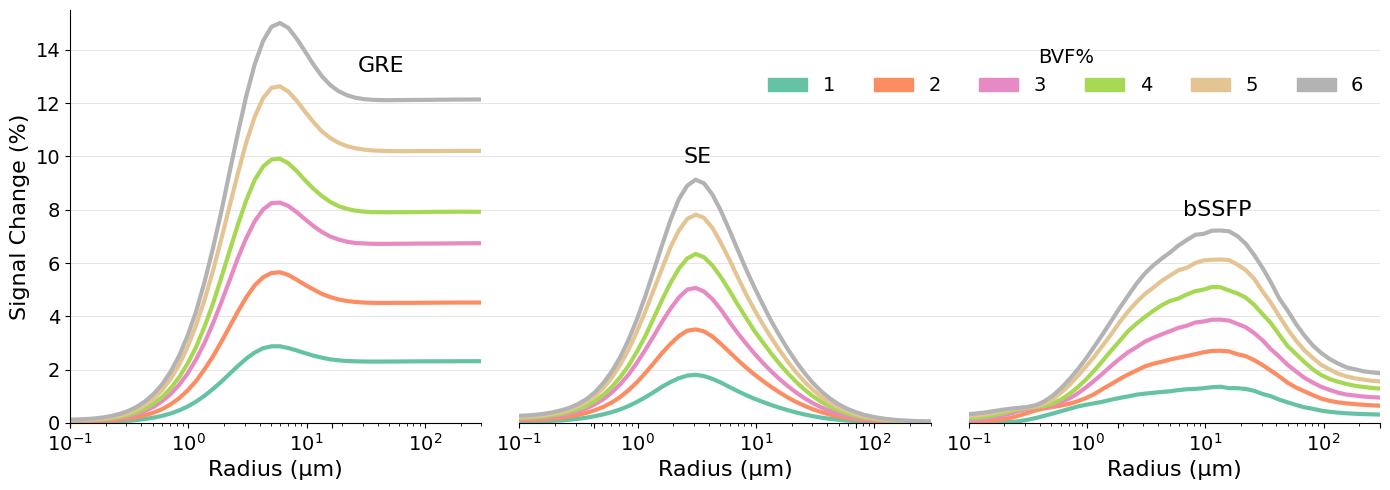

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


plt.rcParams['svg.fonttype'] = 'none' # to embed fonts in SVG output

# Create data
x = radius * scales.squeeze()
x = x.reshape(-1)

# Create a figure and a 3D axis
plt.close('all')
BV   = [1, 2, 3, 4, 5, 6]
cmap = plt.get_cmap('Set2')
colors = cmap(np.linspace(0, 1, len(signal_change_gre)))
fig, axs = plt.subplots(1, 3, figsize=(14, 5))
for i, (ax, sig) in enumerate(zip(axs, [signal_change_gre, signal_change_se, signal_change_ssfp])):
    for s, color, b in zip(sig, colors, BV):
        ax.plot(x, s, color=color, linewidth=3)
    ax.set_xlabel('Radius (µm)', fontsize=16)   
    ax.set_xscale('log')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlim([0.1, 300])
    ax.set_ylim([0, 15.5])
    ax.patch.set_visible(False)

    ax.tick_params(axis='both', which='major', labelsize=14)

    if i == 0:
        ax.set_ylabel('Signal Change (%)', fontsize=16)
        ax.text(0.7, 0.85, 'GRE', transform=ax.transAxes, fontsize=16)
    if i == 1:
        ax.text(0.4, 0.63, 'SE', transform=ax.transAxes, fontsize=16)
    if i == 2:
        ax.text(0.52, 0.5, 'bSSFP', transform=ax.transAxes, fontsize=16)
    if i != 0:
        ax.set_yticklabels([])
        ax.spines['left'].set_visible(False)
        ax.tick_params(axis='y', left=False)

# shared axes for the grid
ax_g = fig.add_subplot(111, zorder=-1)
ax_g.spines[['right', 'top', 'left', 'bottom']].set_visible(False)
ax_g.tick_params(labelleft=False, labelbottom=False, left=False, right=False )
ax_g.set_ylim([0, 15.5])
ax_g.yaxis.grid(True, linewidth=0.7, color='#e5e5e5')
ax_g.patch.set_visible(False)

# Create custom patches for the legend
patches = [mpatches.Patch(color=c, label=f'{b}') for (c, b) in zip(colors, BV)]
fig.legend(handles=patches, title='BVF%', bbox_to_anchor=(.99, .93), ncols=6, frameon=False, fontsize=14, title_fontsize=14)
# fig.patch.set_visible(False)

fig.tight_layout()
plt.savefig('./figures/BVF.svg', format='svg', dpi=1200, bbox_inches='tight')
plt.savefig('./figures/BVF.pdf', format='pdf', dpi=1200, bbox_inches='tight')